In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import numpy as np

In [2]:
data_dir = os.path.expanduser('~/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/processed_data')
out_dir = os.path.expanduser('~/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/external_selfResp_combined')
filename = 'externalMeasures_county.csv'

county_data = pd.read_csv(os.path.join(data_dir, filename))
county_data['state_county'] = county_data['state'] +'_' +county_data['county']
county_data = county_data.loc[~(county_data['county'].isna()) & ~(county_data['state'].isna()),:]

wave_to_week = pd.read_csv(os.path.join(data_dir, 'wave_to_week.csv'))
county_data = county_data.merge(wave_to_week[['wave', 'wave_week']], on='wave', how = 'left')
county_data = county_data.rename(columns={'wave_week': 'week'})
county_data.loc[county_data.gatherBan_N_limit == 'No ban', 'gatherBan_N_limit'] = np.nan
county_data.gatherBan_N_limit = county_data.gatherBan_N_limit.astype('float')



# functions

In [4]:
###########################################################################################################################
# code from Yanting Han: https://github.com/adolphslab/CovidDynamic_dataRelease/blob/main/figures-tables/TempTrends_ExmplVars%20/IDforplot.py
# Farthest point sampling
def calc_distances(p0, points):
    return np.sqrt(((p0 - points)**2.).sum(axis=1))

def farthest_points(pts, pt_labels, K,ii):
    ndims = pts.shape[1] #5 dims
    farthest_pts = np.zeros((K, ndims)) # specify format for wanted points, 5/10 people*5 dim
    farthest_pts[0] = pts[ii]  
    farthest_pts_labs = []
    farthest_pts_labs.append(pt_labels[ii]) # append label 
    distances = calc_distances(farthest_pts[0], pts) # calculate dist for this subject with all other ones

    for ij in range(1, K):
        farthest_pts[ij] = pts[np.argmax(distances)] #returns the index of the subject with the furthest dist
        farthest_pts_labs.append(pt_labels[np.argmax(distances)])
        distances = np.minimum(distances, calc_distances(farthest_pts[ij], pts))
        # for the rest of the points, update the distance to be the min to the already chosen ones
    return farthest_pts, farthest_pts_labs

# maximum variation sampling (eucl.-dist)
def max_var_sampling(value_array, id_lables, K):
    all_sols_dists = []
    all_sols_feats = []
    all_sols_names = []
    for iter_ii in range(value_array.shape[0]):
        solution_set, solution_labels = farthest_points(value_array,id_lables,K, iter_ii)
        all_sols_feats.append(solution_set)
        all_sols_names.append(solution_labels)
        all_sols_dists.append(np.sum(pdist(solution_set, metric='euclidean')))

    best_sols_feats = all_sols_feats[np.argmax(all_sols_dists)]
    best_sols_labels = all_sols_names[np.argmax(all_sols_dists)]
    return best_sols_feats, best_sols_labels
###########################################################################################################################

# summarize restriction data

In [5]:
county_data['stayAtHomeOrder'] = county_data['stayHome_action'].copy()
county_data['stayAtHomeOrder'].replace({'No order for individuals to stay home':0,
                                        'Advisory/Recommendation':1,
                                        'Mandatory only for at-risk individuals in certain areas of the jurisdiction':2,
                                        'Mandatory only for at-risk individuals in the jurisdiction': 3,
                                        'Mandatory only for all individuals in certain areas of the jurisdiction':4,
                                        'Mandatory for all individuals':5}, inplace = True)

county_data['gatherBan'] = county_data['gatherBan_action'].copy()
county_data['gatherBan'].replace({'No order found':0,
                                  'Ban of gatherings over 101 or more people':1,
                                  'Ban of gatherings over 51-100 people':2,
                                  'Ban of gatherings over 26-50 people': 3,
                                  'Ban of gatherings over 11-25 people':4,
                                  'Ban of gatherings over 1-10 people':5,
                                  'Bans gatherings of any size': 6}, inplace = True)



county_data['restaurant_restriction'] = county_data['rest_action'].copy()
county_data['restaurant_restriction'].replace({'Authorized to fully reopen':0,
                                               'Open with social distancing/reduced seating/enhanced sanitation':1,
                                               'Curbside/carryout/delivery only':2}, inplace = True)

county_data['bar_restriction'] = county_data['bar_action'].copy()
county_data['bar_restriction'].replace({'Authorized to fully reopen':0,
                                        'Open with social distancing/reduced seating/enhanced sanitation':1,
                                        'Curbside/carryout/delivery only':2,
                                        'Closed':3}, inplace = True)


county_data_anonymous = county_data.drop(['PROLIFIC_PID', 'loc_description', 'flag'], axis=1)

county_data_anonymous = county_data_anonymous.loc[county_data_anonymous.wave_day == 'start_date', :]
county_data_anonymous = county_data_anonymous.drop_duplicates().reset_index(drop = True)
county_data_anonymous

missing_restriction = county_data_anonymous[['wave', 
             'state_county',
             'stayAtHomeOrder',
             'gatherBan',
             'bar_restriction',
             'restaurant_restriction']].pivot(index = 'state_county',
                                       columns = 'wave', 
                                       values=['stayAtHomeOrder', 
                                               'restaurant_restriction',
                                               'bar_restriction', 
                                               'gatherBan']).isnull().all(1)
county_missing_restriction = list(missing_restriction[missing_restriction == True].index)

missing_covid_cases = county_data_anonymous[['wave', 
             'state_county',
             'cases_avg_per_100k']].pivot(index = 'state_county',
                                       columns = 'wave', 
                                       values=['cases_avg_per_100k']).isnull().all(1)
county_missing_covid_cases = list(missing_covid_cases[missing_covid_cases == True].index)


# drop counties lacking all any data 
county_data = county_data.loc[~county_data.state_county.isin(county_missing_restriction),:].copy()
county_data.fillna({'stayAtHomeOrder':0, 
                          'restaurant_restriction':0,
                         'bar_restriction':0,
                         'gatherBan':0}, inplace=True)
county_data['restriction_sum'] = county_data['stayAtHomeOrder'] + county_data['gatherBan'] + county_data['bar_restriction'] + county_data['restaurant_restriction']

# drop counties missing covid cases
county_data = county_data.loc[~county_data.state_county.isin(county_missing_covid_cases),:].copy()
county_data.to_csv(os.path.join(out_dir, 'externalMeasures_withRestrictionSum_county.csv'),index = False)



In [12]:
county_data.bar_lim_general_intdoor.unique()

array([nan, 'Yes'], dtype=object)

# visualize maximally different timecourses

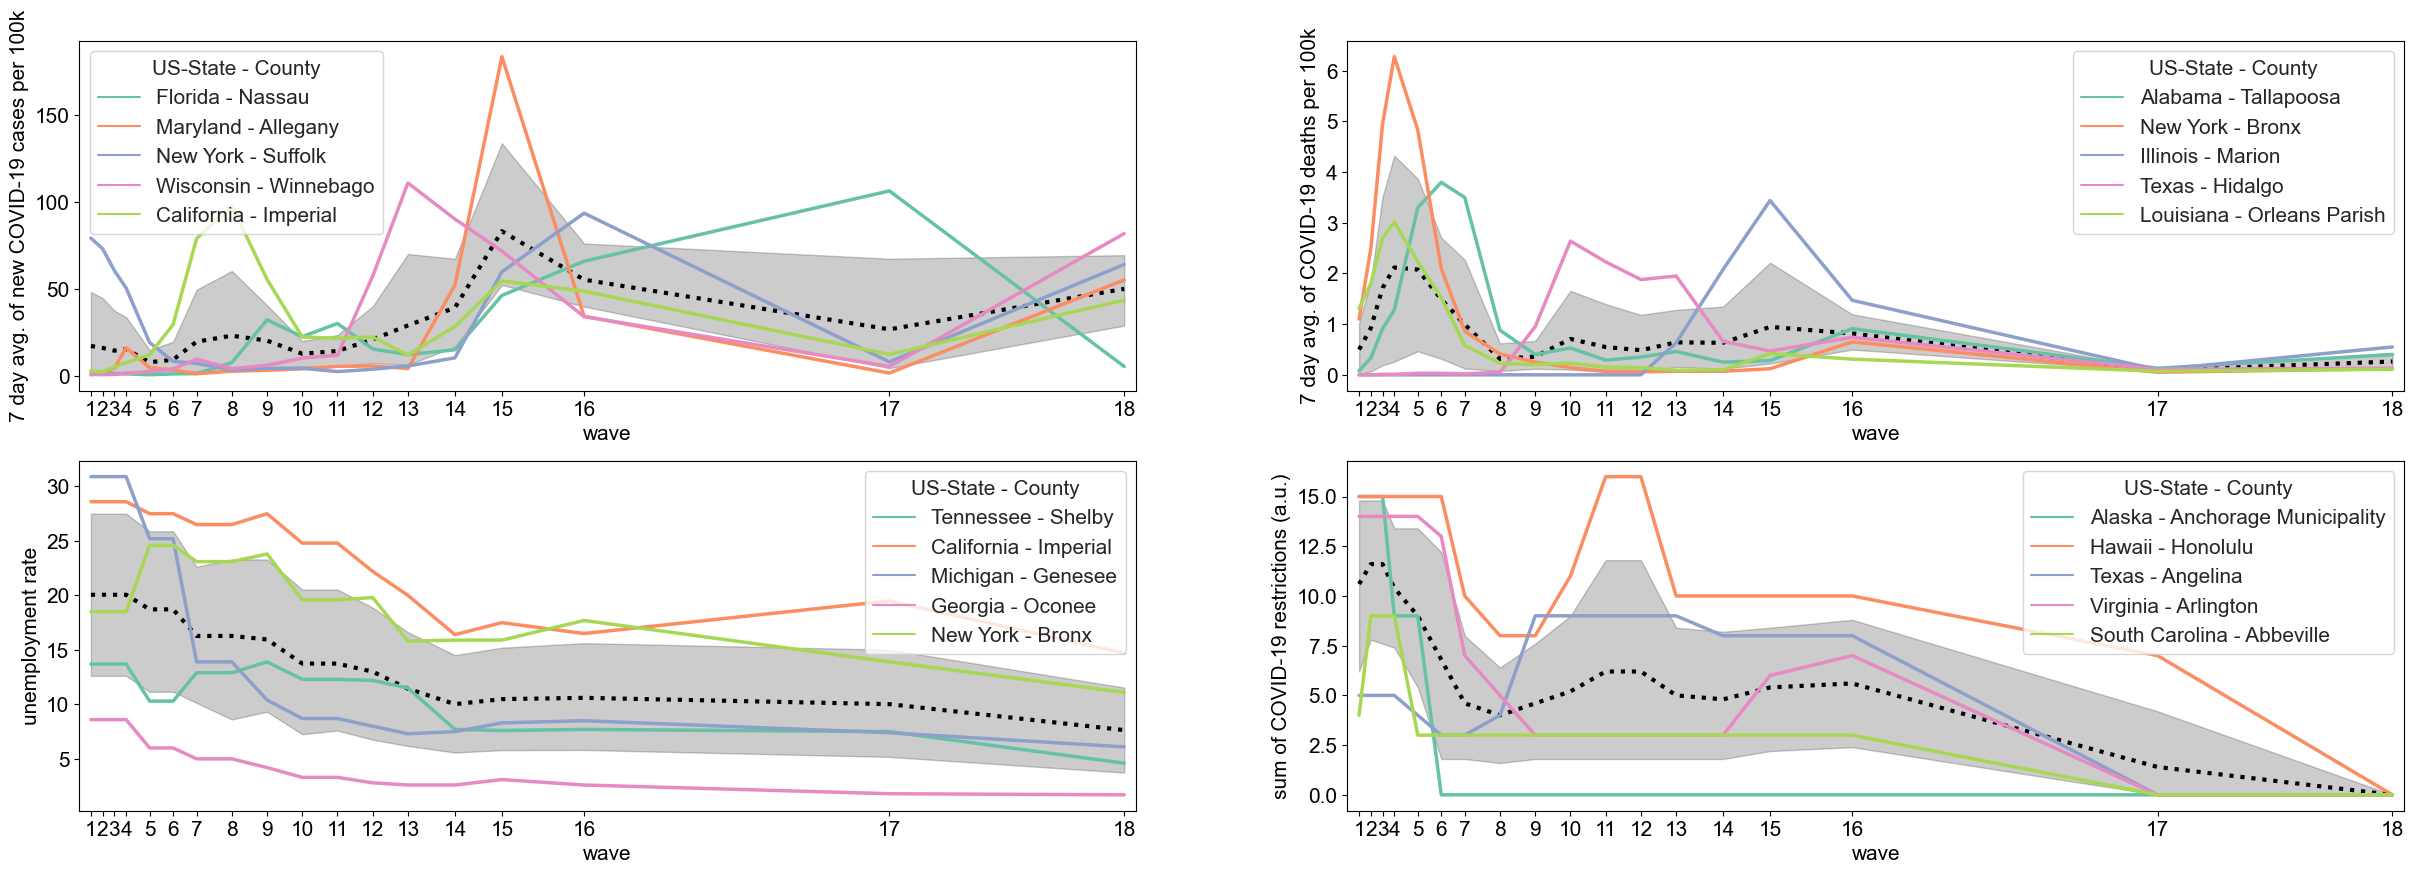

In [6]:
plt.rcParams.update({'font.size': 15}) 
measures = ['cases_avg_per_100k','deaths_avg_per_100k', 'ueRate','restriction_sum']
y_labels = ['7 day avg. of new COVID-19 cases per 100k', '7 day avg. of COVID-19 deaths per 100k', 
            'unemployment rate', 'sum of COVID-19 restrictions (a.u.)']

fig, ax = plt.subplots(2,2,figsize = (30,10))


for idx,m in enumerate(measures):
    row = int(idx/2)
    col = idx%2
    
    val_var = m
    county_maxVar = county_data[['state_county', 'week','wave', val_var]].copy()
    county_maxVar = county_maxVar.drop_duplicates(['state_county','week'])
    county_maxVar = county_maxVar.pivot(index = 'state_county', columns = ['week','wave'], values = val_var)
    county_maxVar = county_maxVar.dropna(axis = 0)


    K = 5
    value_array = county_maxVar.values
    id_lables = county_maxVar.index
    best_sols_feats, best_sols_labels = max_var_sampling(value_array, id_lables, K)
    most_dist = county_maxVar.loc[best_sols_labels].copy()
    most_dist = most_dist.T
    most_dist = pd.DataFrame(most_dist.stack()).reset_index().rename(columns = {0:'value'})
    most_dist['state_county'] = most_dist['state_county'].str.replace('_', ' - ')
    most_dist['state_county'] = most_dist['state_county'].str.title()
    most_dist = most_dist.rename(columns = {'state_county': 'US-State - County'})

    sns.set_style("whitegrid")
    sns.lineplot(data = most_dist, x = 'week', y = 'value', color='black', linewidth=3, linestyle = ':', ax = ax[row,col])
    sns.lineplot(data = most_dist, x = 'week', y = 'value', hue ='US-State - County', ax = ax[row,col], linewidth=2.5,palette = "Set2")
    ax[row,col].set(ylabel=y_labels[idx])

    ax[row,col].set_xticks(most_dist.week.unique());
    ax[row,col].set_xticklabels(most_dist.wave.unique());
    ax[row,col].set_xlabel('wave');


    ax[row,col].set_xlim(0,90)
    